In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import gymnasium as gym
import numpy as np
from envs.dubins_car import DubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

In [2]:
jax.default_backend()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


'cpu'

In [307]:
#generate data

x_s = np.linspace(-4,4, 15)
y_s = np.linspace(-4,4, 15)
theta_s = np.linspace(0,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(len(grid)):
    state = env.set(grid[i][0], grid[i][1], grid[i][2])
    X.append(state)

X_grid = np.array(X)
y_grid = np.array(y)
len(X_grid)


/ifs/CS/replicated/home/apraka15/Desktop/Projects/Reach-Avoid/gym-examples/.env/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


3375

In [308]:


def uniform_samples(env, n):

    state = env.reset()
    X_rand = []
    for i in range(1000):
        state = env.reset()
        X_rand.append(state)
        for action in range(env.action_space.n):
            next_state, reward, done, _ = env.step(state, action, update_env=False)
            X_rand.append(next_state)
    return np.array(X_rand)


X = uniform_samples(env,1000)
X_val = uniform_samples(env,2000)


In [309]:
X = np.vstack([X, X_grid])
np.random.shuffle(X)
#X = np.flip(X,0)
len(X)

8375

In [310]:
# def filter(X):
#     filted_X = []
#     for x in X:
#         # calculate distance to goal and obstacle
#         dist_obstacle = np.linalg.norm(x[:2] - env.obstacle_position) - env.obstacle_radius
#         if dist_obstacle > 0: 
#             dist_goal = np.linalg.norm(x[:2] - env.goal_position) - env.min_distance_to_goal
#             if dist_goal > 0:
#                 filted_X.append(x)
#     return np.array(filted_X)

# X = filter(X)

In [311]:
def plot_surface(X,env, file_name=None, y_pred=None):
    import matplotlib
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.pyplot as plt
    plt.rcParams['figure.figsize'] = [15, 12]

    # Plot...
    plt.scatter(X[:,0], X[:,1], s=1) # s is a size of marker 
    plt.colorbar(label='estimated value')
    goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

    # draw obstacle
    obstacle = plt.Circle((env.obstacle_position[0], env.obstacle_position[1]), env.obstacle_radius, color='r', fill=False)
    plt.gca().add_artist(obstacle)
    plt.gca().add_artist(goal)


    arrow_len = env.v_max
    # Calculate arrow components
    arrow_dx = arrow_len * np.cos(X[:,2])
    arrow_dy = arrow_len * np.sin(X[:,2])

    if y_pred:
        arrow_colors = cm.jet(y_pred/np.max(y_pred))

    else:
        arrow_colors = 'k'


    plt.quiver(X[:,0], X[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color=arrow_colors)


    plt.jet()
    #plt.show()
    if file_name:
        plt.savefig(file_name)

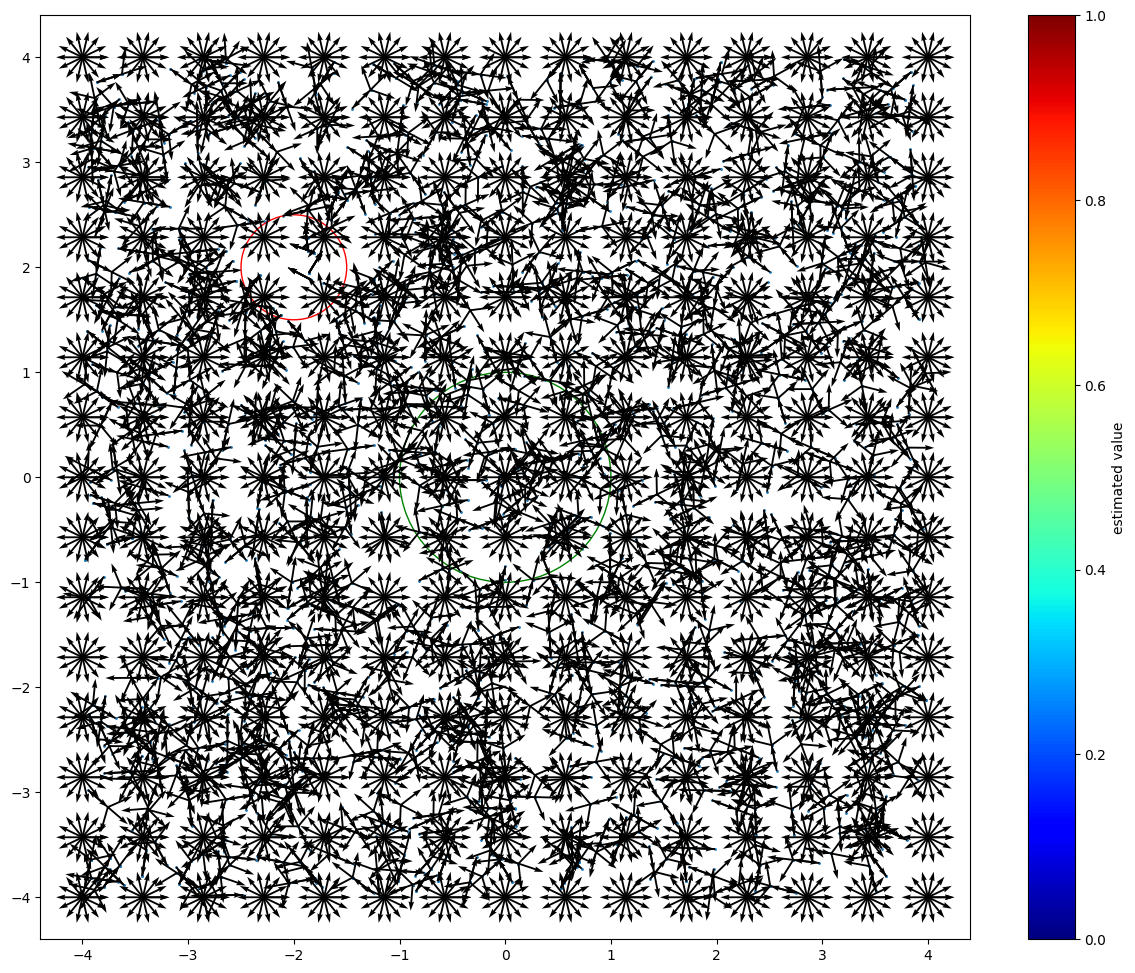

In [312]:
plot_surface(X, env, None)

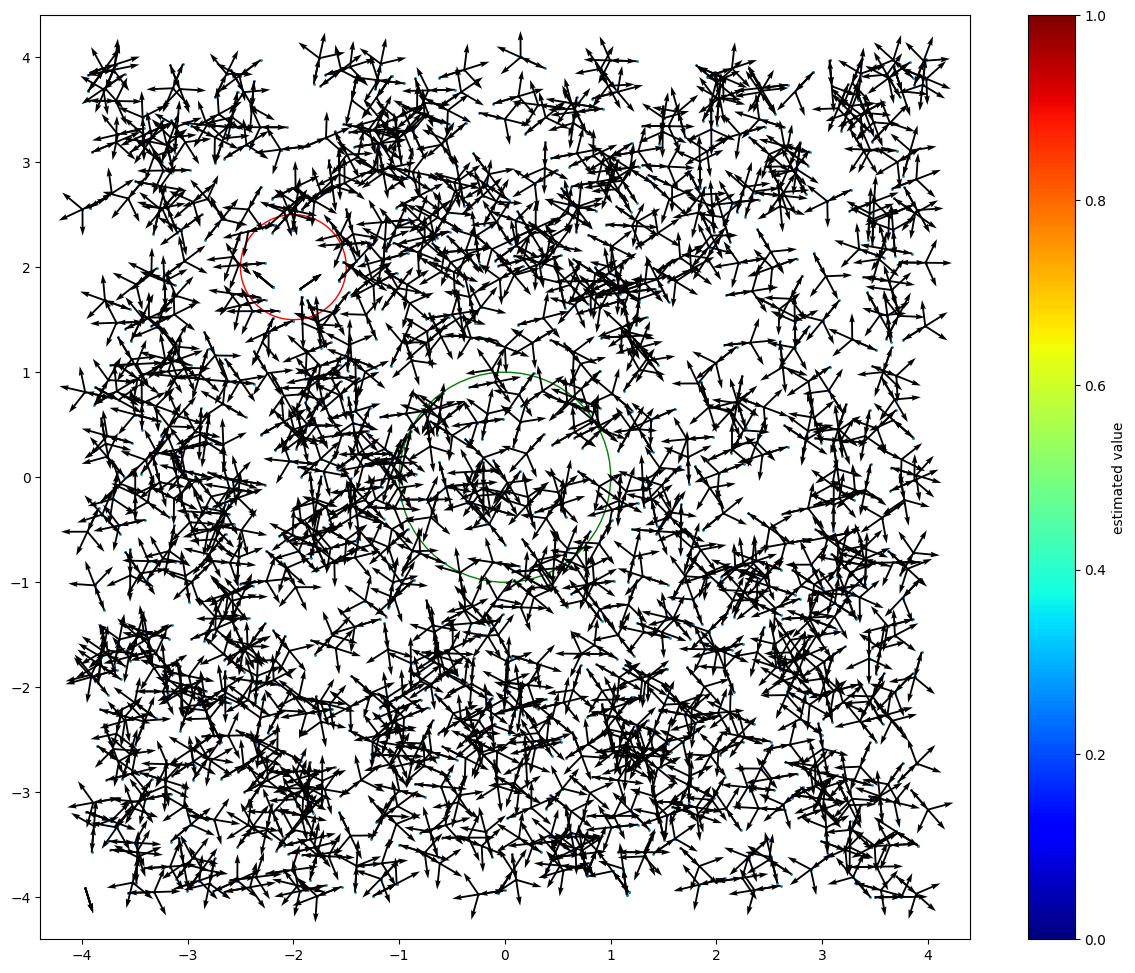

In [313]:
plot_surface(X_val, env)

In [314]:
X = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X)))
X_val = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_val)))

X


array([[-3.42857146e+00, -3.42857146e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 3.09878826e+00, -7.50304341e-01, -9.93498325e-01,
        -1.13846734e-01],
       [-2.28571439e+00,  2.85714293e+00, -1.00000000e+00,
        -8.74227766e-08],
       ...,
       [-1.15719259e+00,  2.26520300e+00,  8.17207873e-01,
        -5.76343060e-01],
       [ 0.00000000e+00, -4.00000000e+00, -6.23489797e-01,
         7.81831503e-01],
       [ 3.43932557e+00,  1.23239374e+00,  6.50255501e-01,
         7.59715617e-01]], dtype=float32)

In [132]:
#params are defined *implicitly* in haiku
# def forward(X):
#     l1 = hk.Linear(16)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(1)(l2)

#     return l3.ravel()


#params are defined *implicitly* in haiku
def forward(X):
    l1 = hk.Linear(12)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(4)(l2)
    l4 = jax.nn.relu(l3)

    l5= hk.Linear(1)(l4)

    return l5
# def forward(X):

#     mlp = hk.nets.MLP(output_sizes=[3,1])
#     return mlp(X)

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse


jiter = jax.jit(env.sample_value_iter)


optimizer = optax.adamw(learning_rate=10e-6)
batch_size = 100 #make it 200-50
losses = []
#check we aren't double using gradients
opt_state = optimizer.init(params)
for epoch in range(500):
    batch_loss = []
    for batch in range(0,len(X), batch_size):
        X_batch = X[batch:batch+batch_size]
        y_batch = env.sample_value_iter(X_batch, forward, params, gamma=0.95)

    
        loss, grads = jax.value_and_grad(loss_fn)(params,X=X_batch,y=y_batch)
        #print("progress:", "epoch:", epoch, "batch loss",loss)
        batch_loss.append(loss)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
    losses.append(np.mean(batch_loss))
    print('epoch', epoch, 'average loss', np.mean(batch_loss))
        
    
    
# After training
print("estimation of the parameters:")
print(params)

# estimate  = forward(X=env.reset(), params=params)
# print("estimate", estimate)

epoch 0 average loss 1.6689799
epoch 1 average loss 1.6543573
epoch 2 average loss 1.6398731
epoch 3 average loss 1.6255051
epoch 4 average loss 1.6112506
epoch 5 average loss 1.5970995
epoch 6 average loss 1.5830215
epoch 7 average loss 1.5690486
epoch 8 average loss 1.5551755
epoch 9 average loss 1.5413918
epoch 10 average loss 1.5276902
epoch 11 average loss 1.5140524
epoch 12 average loss 1.5004636
epoch 13 average loss 1.486912
epoch 14 average loss 1.4734614
epoch 15 average loss 1.460101
epoch 16 average loss 1.4467715
epoch 17 average loss 1.4335215
epoch 18 average loss 1.4203662
epoch 19 average loss 1.4072922
epoch 20 average loss 1.3942331
epoch 21 average loss 1.3812547
epoch 22 average loss 1.3683132
epoch 23 average loss 1.3554398
epoch 24 average loss 1.3426466
epoch 25 average loss 1.3299145
epoch 26 average loss 1.3172587
epoch 27 average loss 1.30468
epoch 28 average loss 1.2921778
epoch 29 average loss 1.2797632
epoch 30 average loss 1.2674214
epoch 31 average loss 

KeyboardInterrupt: 

In [339]:
#params are defined *implicitly* in haiku
# def forward(X):
#     l1 = hk.Linear(16)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(1)(l2)

#     return l3.ravel()


#params are defined *implicitly* in haiku
# def forward(X):
#     l1 = hk.Linear(12)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(12)(l2)
#     l4 = jax.nn.relu(l3)
#     l5 = hk.Linear(12)(l4)
#     l6 = jax.nn.relu(l5)

#     l7= hk.Linear(1)(l6)

#     return l7


def forward(X):
    l1 = hk.Linear(12)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(4)(l2)
    l4 = jax.nn.relu(l3)

    l5= hk.Linear(1)(l4)

    return l5

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse




optimizer = optax.adamw(learning_rate=10e-5)
batch_size = 200 #make it 200-50
losses = []
val_losses = [np.inf]
#check we aren't double using gradients
opt_state = optimizer.init(params)


@jax.jit
def train_step(params, X_batch, y_batch, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, X=X_batch, y=y_batch)
    #updates, opt_state = optimizer.update(grads, opt_state)
    updates, opt_state = optimizer.update(grads,params=params, state= opt_state)

    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

for epoch in range(100):
    epoch_loss = 0.0
    opt_state = optimizer.init(params)
    for batch in range(0, len(X), batch_size):
        X_batch = X[batch:batch+batch_size]
        y_batch = env.sample_value_iter(X_batch, forward, params, gamma=0.99)
        loss, params, opt_state = train_step(params, X_batch, y_batch, opt_state)
        epoch_loss += loss
    epoch_loss /= (len(X) // batch_size)

    y_val = env.sample_value_iter(X_val, forward, params, gamma=0.99)

    val_loss = loss_fn(params, X_val, y_val)
    print("val_loss", val_loss, 'delta' , np.abs(val_loss - val_losses[-1]))
    if np.abs(val_loss - val_losses[-1]) < 0.01:
        print("early stopping")
        break
    val_losses.append(val_loss)


    losses.append(epoch_loss)
    print('epoch', epoch, 'average loss', epoch_loss)

#todo impolement val set for early stopping


val_loss 1.5294677 delta inf
epoch 0 average loss 1.7625108
val_loss 1.4638041 delta 0.065663576
epoch 1 average loss 1.69434
val_loss 1.3970133 delta 0.06679082
epoch 2 average loss 1.6253593
val_loss 1.329409 delta 0.0676043
epoch 3 average loss 1.5553287
val_loss 1.2609526 delta 0.06845641
epoch 4 average loss 1.4844661
val_loss 1.192286 delta 0.06866658
epoch 5 average loss 1.4128454
val_loss 1.1234248 delta 0.068861246
epoch 6 average loss 1.3410041
val_loss 1.055079 delta 0.068345785
epoch 7 average loss 1.2692646
val_loss 0.9878189 delta 0.06726009
epoch 8 average loss 1.1982489
val_loss 0.92170686 delta 0.06611204
epoch 9 average loss 1.1283983
val_loss 0.8572489 delta 0.06445795
epoch 10 average loss 1.0597459
val_loss 0.7939174 delta 0.063331485
epoch 11 average loss 0.99214387
val_loss 0.73254395 delta 0.061373472
epoch 12 average loss 0.9260508
val_loss 0.6734064 delta 0.059137523
epoch 13 average loss 0.86163974
val_loss 0.61696386 delta 0.05644256
epoch 14 average loss 0.

KeyboardInterrupt: 

In [325]:
# Plot the losses
lo = [l.item() for l in losses]
vlo = [l for l in val_losses]


plt.plot(lo, label='training loss')
plt.plot(vlo, label='validation loss')

# Add a title and labels to the x and y axis
plt.legend()
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Show the plot
plt.savefig('losses_3.png')

plt.show()

In [243]:
#generate data

x_s = np.linspace(-4,4, 20)
y_s = np.linspace(-4,4, 20)
theta_s = np.linspace(0,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid_test = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X_test = []
for i in range(len(grid_test)):
    state = env.set(grid_test[i][0], grid_test[i][1], grid_test[i][2])
    X_test.append(state)

X_test = np.array(X_test)

X_test_encoded = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_test)))
X_test_encoded

/ifs/CS/replicated/home/apraka15/Desktop/Projects/Reach-Avoid/gym-examples/.env/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


array([[-4.0000000e+00, -4.0000000e+00,  1.0000000e+00,  0.0000000e+00],
       [-4.0000000e+00, -4.0000000e+00,  9.0096885e-01,  4.3388376e-01],
       [-4.0000000e+00, -4.0000000e+00,  6.2348980e-01,  7.8183150e-01],
       ...,
       [ 4.0000000e+00,  4.0000000e+00,  6.2348962e-01, -7.8183162e-01],
       [ 4.0000000e+00,  4.0000000e+00,  9.0096885e-01, -4.3388376e-01],
       [ 4.0000000e+00,  4.0000000e+00,  1.0000000e+00,  1.7484555e-07]],
      dtype=float32)

In [340]:



y_pred = [forward(X=x, params=params) for x in X_test_encoded]

In [341]:
y_pred

[Array([0.80755246], dtype=float32),
 Array([0.8103319], dtype=float32),
 Array([0.8099315], dtype=float32),
 Array([0.77721375], dtype=float32),
 Array([0.7151947], dtype=float32),
 Array([0.615413], dtype=float32),
 Array([0.5258113], dtype=float32),
 Array([0.4819798], dtype=float32),
 Array([0.48761207], dtype=float32),
 Array([0.5330781], dtype=float32),
 Array([0.6075233], dtype=float32),
 Array([0.66748136], dtype=float32),
 Array([0.7290115], dtype=float32),
 Array([0.77900225], dtype=float32),
 Array([0.80755246], dtype=float32),
 Array([0.76222044], dtype=float32),
 Array([0.79736143], dtype=float32),
 Array([0.80400944], dtype=float32),
 Array([0.77191806], dtype=float32),
 Array([0.6922625], dtype=float32),
 Array([0.5924809], dtype=float32),
 Array([0.50287914], dtype=float32),
 Array([0.4412041], dtype=float32),
 Array([0.4397729], dtype=float32),
 Array([0.4852389], dtype=float32),
 Array([0.56153345], dtype=float32),
 Array([0.6335721], dtype=float32),
 Array([0.6879705

In [342]:
max(y_pred)

Array([0.8252609], dtype=float32)

In [343]:
env.obstacle_position

array([-2,  2])

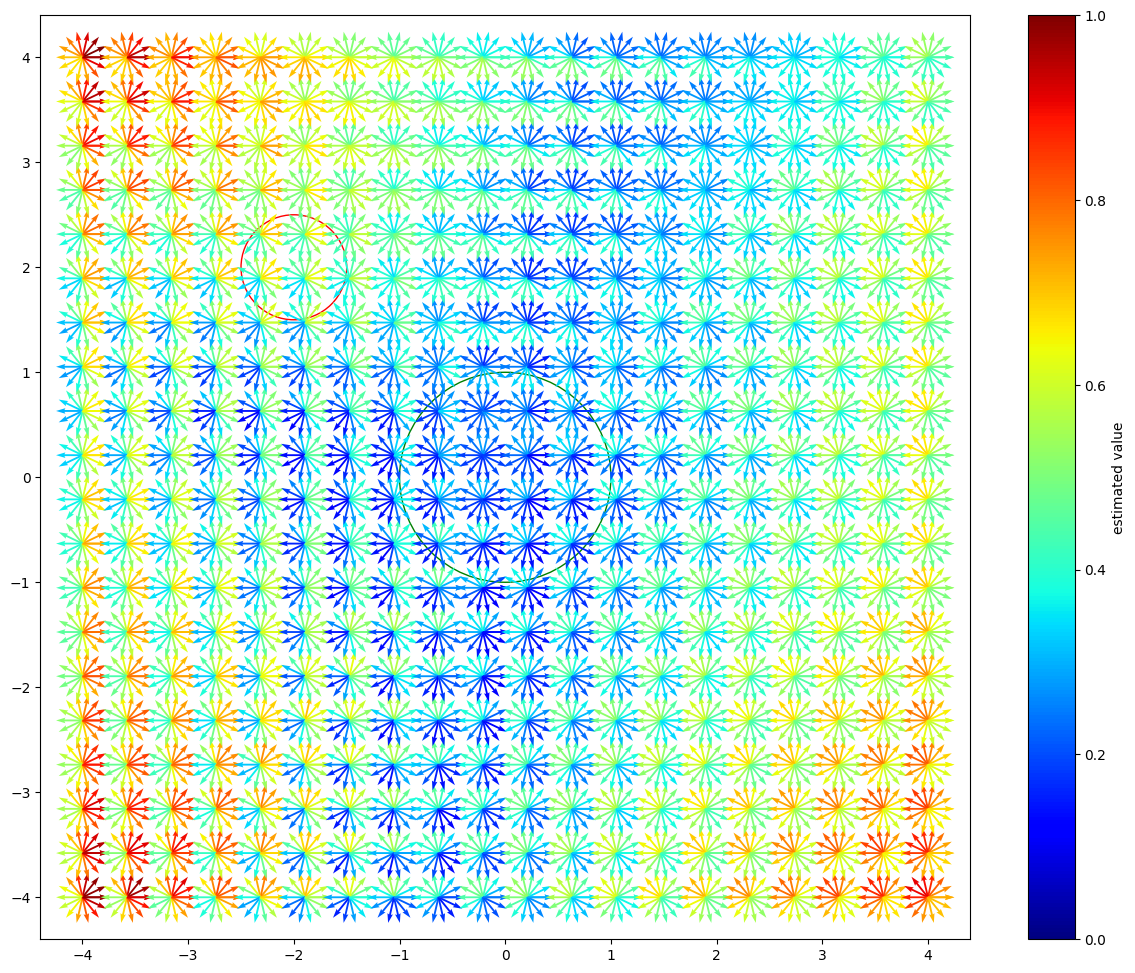

In [344]:
plot_surface(X_test, env, 'experiment.png', y_pred)

In [ ]:
len(X)

5500

In [322]:
#train on small steps, run on bigger steps?
right = 0
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi

env = DubinsCarEnv()
state = env.set(-3, 3, right)
#state = env.reset()

gamma = 0.95
traj = []
done = False
max_iter = 50
counter = 0
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for a in range(env.action_space.n):
        next_state, reward, done, _ = env.step(state, a, update_env=False)
        #estimate = forward(X=next_state, params=params)
        estimate = forward(X=np.array([next_state[0], next_state[1], np.cos(next_state[2]), np.sin(next_state[2])]), params=params)

        value = reward + gamma*estimate[0]


        possible_actions.append(value)

    action = np.argmax(np.array(possible_actions))
    traj.append(state)
    state, reward, done, _ = env.step(action=action, update_env=True)
    env.render()
    print(counter)
    
env.make_gif()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
t = np.array([traj])
yp = [forward(X=x, params=params) for x in t]

# Plot...
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], c=yp, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()
#plt.savefig('500_iter.png')

ValueError: 'linear/w' with retrieved shape (4, 12) does not match shape=[3, 12] dtype=dtype('float32')

In [ ]:
10*estimate

Array([-31.93895], dtype=float32)

: 

In [ ]:
possible_actions

[Array(-12.71481, dtype=float32),
 Array(-12.356915, dtype=float32),
 Array(-12.71481, dtype=float32)]

: 

In [ ]:
np.argmax(possible_actions)

1

: 

In [ ]:
forward(X=np.array([3,3,0, 0]), params=params) 

Array([-2.9606214], dtype=float32)

: 

In [ ]:
forward(X=np.array([3,3,1, 1]), params=params) 

Array([-2.536736], dtype=float32)

: 

In [ ]:
#plot with arrows and try without obstacle. 

: 